# Merging Climate Datasets Answer Key

This notebook demonstrates how to merge two gridded climate datasets that differ in their spatial and temporal resolutions using `xarray`. We will:

- Access two public NOAA datasets from THREDDS servers
- Harmonize their coordinates and resolutions with `xr.resample` and `xr.interp`
- Merge them into a single dataset with `xr.merge` for joint analysis


## 1. Imports and configuration


In [2]:
import matplotlib.pyplot as plt
import xarray as xr

try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
except ImportError:
    ccrs = None
    cfeature = None

TEMP_URL = "https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.2020.nc"
PRECIP_URL = "https://psl.noaa.gov/thredds/dodsC/Datasets/cpc_global_precip/precip.2020.nc"

LAT_RANGE = (20, 50)  # degrees North
LON_RANGE_360 = (230, 300)  # degrees East (equivalent to -130° to -60°)
LON_RANGE_180 = (-130, -60)  # degrees relative to Greenwich

TIME_RANGE = slice("2020-06-01", "2020-06-30")


The two datasets we will use are:

- **NCEP/NCAR Reanalysis 1** surface air temperature (`air.sig995`), available every 6 hours on a 2.5° grid.
- **CPC Global Unified Gauge-based Analysis** of daily precipitation, available daily on a 0.5° grid.

Both datasets cover the United States, differ in temporal cadence and spatial resolution, and already share the same 0–360° longitude convention. Our goal is to create a merged dataset containing daily mean temperature and precipitation on a common 0.5° grid.


## 2. Open the remote datasets

`xarray` can lazily stream data from remote THREDDS servers using `open_dataset`. We apply simple chunking to keep operations memory-friendly.


In [3]:
air = xr.open_dataset(TEMP_URL, chunks={"time": 8})
precip = xr.open_dataset(PRECIP_URL, chunks={"time": 31})

air, precip


(<xarray.Dataset> Size: 62MB
 Dimensions:  (time: 1464, lat: 73, lon: 144)
 Coordinates:
   * lat      (lat) float32 292B 90.0 87.5 85.0 82.5 ... -82.5 -85.0 -87.5 -90.0
   * lon      (lon) float32 576B 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
   * time     (time) datetime64[ns] 12kB 2020-01-01 ... 2020-12-31T18:00:00
 Data variables:
     air      (time, lat, lon) float32 62MB dask.array<chunksize=(8, 73, 144), meta=np.ndarray>
 Attributes:
     Conventions:                     COARDS
     title:                           4x daily NMC reanalysis (2014)
     history:                         created 2017/12 by Hoop (netCDF2.3)
     description:                     Data is from NMC initialized reanalysis\...
     platform:                        Model
     dataset_title:                   NCEP-NCAR Reanalysis 1
     _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
     References:                      http://www.psl.noaa.gov/data/gridded/dat...
     DODS_EXTRA.

## 3. Spatial and temporal subsetting

To reduce data volume, we focus on June 2020 over the continental United States.

Because both products express longitude from 0° to 360°, the continental US spans roughly 230°E–300°E. The helper below adapts to each dataset's coordinate ordering.


In [4]:
def oriented_slice(coord, bounds):
    values = coord.to_numpy()
    start, end = bounds
    forward = float(values[0]) < float(values[-1])
    return slice(start, end) if forward else slice(end, start)

def select_lon_bounds(coord):
    values = coord.to_numpy()
    bounds = LON_RANGE_360 if float(values.min()) >= 0 else LON_RANGE_180
    return oriented_slice(coord, bounds)

air_us = air.sel(
    time=TIME_RANGE,
    lat=oriented_slice(air.lat, LAT_RANGE),
    lon=select_lon_bounds(air.lon),
)
precip_us = precip.sel(
    time=TIME_RANGE,
    lat=oriented_slice(precip.lat, LAT_RANGE),
    lon=select_lon_bounds(precip.lon),
)

air_us, precip_us


(<xarray.Dataset> Size: 182kB
 Dimensions:  (time: 120, lat: 13, lon: 29)
 Coordinates:
   * lat      (lat) float32 52B 50.0 47.5 45.0 42.5 40.0 ... 27.5 25.0 22.5 20.0
   * lon      (lon) float32 116B 230.0 232.5 235.0 237.5 ... 295.0 297.5 300.0
   * time     (time) datetime64[ns] 960B 2020-06-01 ... 2020-06-30T18:00:00
 Data variables:
     air      (time, lat, lon) float32 181kB dask.array<chunksize=(8, 13, 29), meta=np.ndarray>
 Attributes:
     Conventions:                     COARDS
     title:                           4x daily NMC reanalysis (2014)
     history:                         created 2017/12 by Hoop (netCDF2.3)
     description:                     Data is from NMC initialized reanalysis\...
     platform:                        Model
     dataset_title:                   NCEP-NCAR Reanalysis 1
     _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
     References:                      http://www.psl.noaa.gov/data/gridded/dat...
     DODS_EXTRA.Unli

## 4. Match temporal resolution with `xr.resample`

The air temperature is reported every six hours. We compute daily means to match the precipitation cadence using `xr.resample(time="1D")`.


In [5]:
air_daily = air_us["air"].resample(time="1D").mean()
air_daily


<xarray.DataArray 'air' (time: 30, lat: 13, lon: 29)> Size: 45kB
dask.array<stack, shape=(30, 13, 29), dtype=float32, chunksize=(1, 13, 29), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 52B 50.0 47.5 45.0 42.5 40.0 ... 27.5 25.0 22.5 20.0
  * lon      (lon) float32 116B 230.0 232.5 235.0 237.5 ... 295.0 297.5 300.0
  * time     (time) datetime64[ns] 240B 2020-06-01 2020-06-02 ... 2020-06-30
Attributes: (12/13)
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    ...            ...
    parent_stat:   Other
    valid_range:   [185.16 331.16]
    dataset:       NCEP Reanalysis
    actual_range:  [188.6 324.1]
    level_desc:    0.995 sigma
    _ChunkSizes:   [  1  73 144]

## 5. Match spatial resolution with `xr.interp`

The precipitation grid is denser (0.5°). Interpolate the coarser air temperature field onto the precipitation grid.


In [6]:
air_interp = air_daily.interp(lat=precip_us.lat, lon=precip_us.lon)
air_interp


<xarray.DataArray 'air' (time: 30, lat: 60, lon: 140)> Size: 1MB
dask.array<transpose, shape=(30, 60, 140), dtype=float32, chunksize=(1, 60, 140), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 240B 2020-06-01 2020-06-02 ... 2020-06-30
  * lat      (lat) float32 240B 49.75 49.25 48.75 48.25 ... 21.25 20.75 20.25
  * lon      (lon) float32 560B 230.2 230.8 231.2 231.8 ... 298.8 299.2 299.8
Attributes: (12/13)
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    ...            ...
    parent_stat:   Other
    valid_range:   [185.16 331.16]
    dataset:       NCEP Reanalysis
    actual_range:  [188.6 324.1]
    level_desc:    0.995 sigma
    _ChunkSizes:   [  1  73 144]

## 6. Merge the harmonized datasets

Once the data share the same grid and cadence, `xr.merge` combines them into a single dataset.


In [7]:
air_ds = air_interp.to_dataset(name="air_temperature")
precip_ds = precip_us["precip"].to_dataset(name="daily_precip")

merged = xr.merge([air_ds, precip_ds])
merged


<xarray.Dataset> Size: 2MB
Dimensions:          (time: 30, lat: 60, lon: 140)
Coordinates:
  * time             (time) datetime64[ns] 240B 2020-06-01 ... 2020-06-30
  * lat              (lat) float32 240B 49.75 49.25 48.75 ... 21.25 20.75 20.25
  * lon              (lon) float32 560B 230.2 230.8 231.2 ... 298.8 299.2 299.8
Data variables:
    air_temperature  (time, lat, lon) float32 1MB dask.array<chunksize=(1, 60, 140), meta=np.ndarray>
    daily_precip     (time, lat, lon) float32 1MB dask.array<chunksize=(3, 60, 140), meta=np.ndarray>

## 7. Quick sanity checks

We confirm that both variables now have identical dimensions and a few simple statistics look reasonable.


In [8]:
print(dict(merged.dims))
temp_min = float(merged.air_temperature.min().compute())
temp_max = float(merged.air_temperature.max().compute())
precip_min = float(merged.daily_precip.min().compute())
precip_max = float(merged.daily_precip.max().compute())
print(temp_min, temp_max)
print(precip_min, precip_max)


/tmp/ipykernel_286015/2705525366.py:1: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(dict(merged.dims))


{'time': 30, 'lat': 60, 'lon': 140}
274.5037536621094 306.718017578125
0.0 213.58189392089844


## 8. Example visualization (optional)

Plotting provides a visual confirmation that the merged grid is consistent.
The cartopy map below renders both fields on a shared projection, and the scatter
plot compares collocated temperature and precipitation values.


Text(0.5, 1.0, 'Collocated temperature vs precipitation')

/home/snesbitt/envs/xarray-climate/lib/python3.13/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


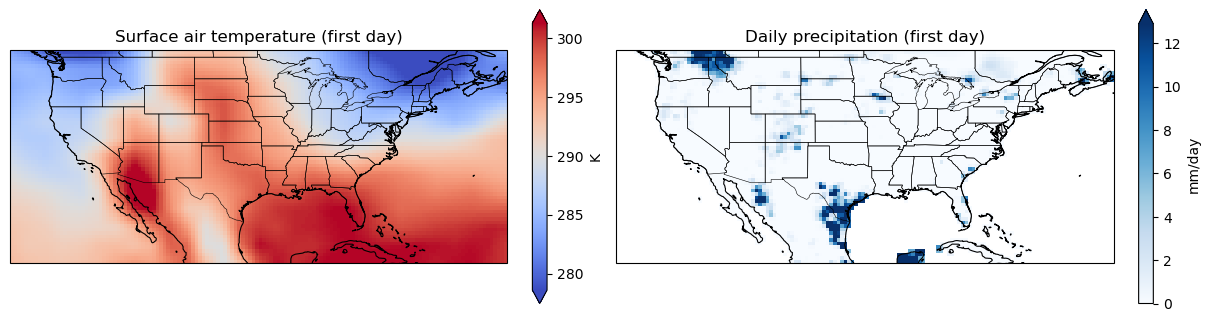

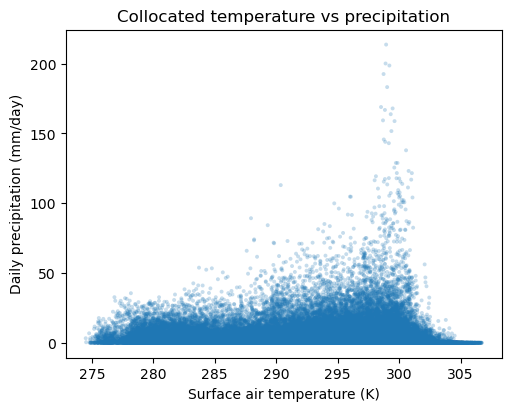

In [9]:
if ccrs is None:
    raise ImportError("Install cartopy to render the projected map (e.g., pip install cartopy).")

temp_slice = merged.air_temperature.isel(time=0).compute()
precip_slice = merged.daily_precip.isel(time=0).compute()

west, east = (LON_RANGE_360[0] - 360, LON_RANGE_360[1] - 360)
south, north = LAT_RANGE

fig, axes = plt.subplots(
    1,
    2,
    figsize=(12, 4),
    subplot_kw={"projection": ccrs.PlateCarree()},
    constrained_layout=True,
)

_ = temp_slice.plot(
    ax=axes[0],
    transform=ccrs.PlateCarree(),
    cmap="coolwarm",
    robust=True,
    add_colorbar=True,
    cbar_kwargs={"shrink": 0.75, "label": "K"},
)
axes[0].set_title("Surface air temperature (first day)")
axes[0].set_extent([west, east, south, north], crs=ccrs.PlateCarree())
axes[0].coastlines(resolution="50m", linewidth=0.8)
if cfeature is not None:
    try:
        axes[0].add_feature(cfeature.STATES.with_scale("50m"), linewidth=0.4, edgecolor="black")
    except Exception:
        pass

_ = precip_slice.plot(
    ax=axes[1],
    transform=ccrs.PlateCarree(),
    cmap="Blues",
    robust=True,
    add_colorbar=True,
    cbar_kwargs={"shrink": 0.75, "label": "mm/day"},
)
axes[1].set_title("Daily precipitation (first day)")
axes[1].set_extent([west, east, south, north], crs=ccrs.PlateCarree())
axes[1].coastlines(resolution="50m", linewidth=0.8)
if cfeature is not None:
    try:
        axes[1].add_feature(cfeature.STATES.with_scale("50m"), linewidth=0.4, edgecolor="black")
    except Exception:
        pass

stacked = merged[["air_temperature", "daily_precip"]].stack(point=("time", "lat", "lon"))
stacked = stacked.dropna(dim="point", how="any").compute()
temp_vals = stacked.air_temperature.values
precip_vals = stacked.daily_precip.values

scatter_fig, scatter_ax = plt.subplots(figsize=(5, 4), constrained_layout=True)
scatter_ax.scatter(temp_vals, precip_vals, s=8, alpha=0.25, edgecolor="none")
scatter_ax.set_xlabel("Surface air temperature (K)")
scatter_ax.set_ylabel("Daily precipitation (mm/day)")
scatter_ax.set_title("Collocated temperature vs precipitation")


## 9. Save merged dataset

Persist the merged result locally if you plan further analysis.


In [12]:
merged.to_netcdf("merged_air_precip_june2020.nc")
